In [1]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
data = read_csv('phy_cps.csv', header=0, index_col=0)
dataset = data[0:1936]
out_dataset = data[1936:]
#values = dataset.values
values = dataset.to_numpy()


In [2]:
#out_dataset.info()


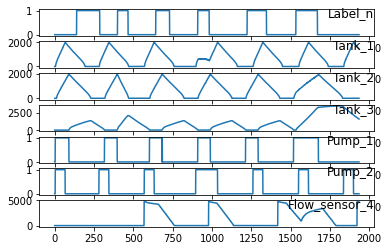

In [3]:

# specify columns to plot
#groups = [0, 1, 2, 3, 5, 6, 7]
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### Multivariate LSTM Forecast Model

In [4]:
from math import sqrt
from numpy import array
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 


In [5]:
values

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0, 1485,    5, ...,    0,    0, 4725],
       [   0, 1471,    4, ...,    0,    0, 4716],
       [   0, 1454,    5, ...,    0,    0, 4707]], dtype=int64)

   var7(t-1)  var1(t)  var2(t)  var3(t)  var4(t)  var5(t)  var6(t)  var7(t)
1        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
2        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
3        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0
4        0.0      0.0      0.0      0.0      0.0      1.0      1.0      0.0
5        0.0      0.0      0.0      0.0      0.0      1.0      1.0      0.0
(1548, 1, 7) (1548,) (871, 1, 7) (871,)
Epoch 1/70
49/49 - 5s - loss: 0.2520 - val_loss: 0.3746 - 5s/epoch - 92ms/step
Epoch 2/70
49/49 - 0s - loss: 0.2268 - val_loss: 0.3622 - 231ms/epoch - 5ms/step
Epoch 3/70
49/49 - 0s - loss: 0.2091 - val_loss: 0.3395 - 232ms/epoch - 5ms/step
Epoch 4/70
49/49 - 0s - loss: 0.1951 - val_loss: 0.3197 - 236ms/epoch - 5ms/step
Epoch 5/70
49/49 - 0s - loss: 0.1824 - val_loss: 0.2931 - 231ms/epoch - 5ms/step
Epoch 6/70
49/49 - 0s - loss: 0.1684 - val_loss: 0.2650 - 218ms/epoch - 4ms/step
Epoch 7/70
49/49 - 0

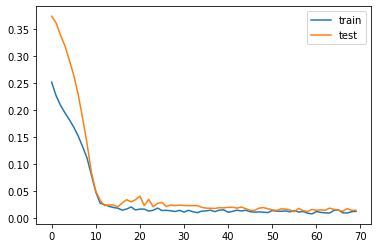

Test RMSE: 0.051


In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset = read_csv('phy_cps.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5]], axis=1, inplace=True)
reframed.drop(reframed.columns[[0,1,2,3,4,5]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
#n_train_hours = 484
#n_train_hours = 1936
n_train_hours = 1548
# Not 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### Out of Sample Testing

   var7(t-1)  var1(t)   var2(t)   var3(t)   var4(t)  var5(t)  var6(t)  \
1   0.982023      0.0  0.719697  0.001546  0.988439      0.0      0.0   
2   0.982023      0.0  0.711616  0.002062  0.979448      0.0      0.0   
3   0.980142      0.0  0.703030  0.002062  0.967245      0.0      0.0   
4   0.978470      0.0  0.697475  0.002062  0.958253      0.0      0.0   
5   0.976589      0.0  0.688889  0.001546  0.944766      0.0      0.0   

    var7(t)  
1  0.982023  
2  0.980142  
3  0.978470  
4  0.976589  
5  0.974916  
Epoch 1/70
49/49 - 0s - loss: 0.0089 - val_loss: 0.0169 - 192ms/epoch - 4ms/step
Epoch 2/70
49/49 - 0s - loss: 0.0104 - val_loss: 0.0160 - 170ms/epoch - 3ms/step
Epoch 3/70
49/49 - 0s - loss: 0.0087 - val_loss: 0.0144 - 167ms/epoch - 3ms/step
Epoch 4/70
49/49 - 0s - loss: 0.0108 - val_loss: 0.0148 - 169ms/epoch - 3ms/step
Epoch 5/70
49/49 - 0s - loss: 0.0083 - val_loss: 0.0131 - 167ms/epoch - 3ms/step
Epoch 6/70
49/49 - 0s - loss: 0.0101 - val_loss: 0.0124 - 212ms/epoch - 

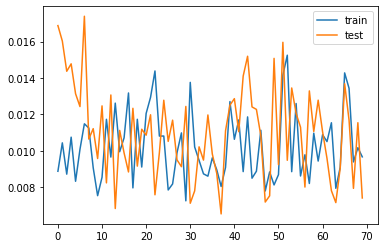

Test RMSE: 0.046


In [7]:
#dataset = out_dataset
t_values = out_dataset.to_numpy()

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
#dataset = read_csv('phy_cps.csv', header=0, index_col=0)
t_values = out_dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
t_values = t_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(t_values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.drop(reframed.columns[[0,1,2,3,4,5]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
t_values = reframed.values
#n_train_hours = 365 * 24
#n_train_hours = 484
#n_train_hours = 1936
#n_train_hours = 1548
# Not 1936
#train = values[:n_train_hours, :]
#test = values[n_train_hours:, :]
test = t_values
# split into input and outputs
#train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# # design network
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')

# fit network
#history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)